
Training Pure ANN (MLP) on 150 random points.
Testing on fixed test set of 2854 points.
Fitting ANN (MLP) model on SCALED y...
Evaluating model...

--- Pure ANN (MLP) Only (No AL) Performance ---
Training size: 150
Test size: 2854
MAE: 2.893e-07 m/s  (0.289 µm/s)
R²: 0.9301
MAPE: 7.38%

Saved 'pure_ann_simple_model.joblib' and scalers.


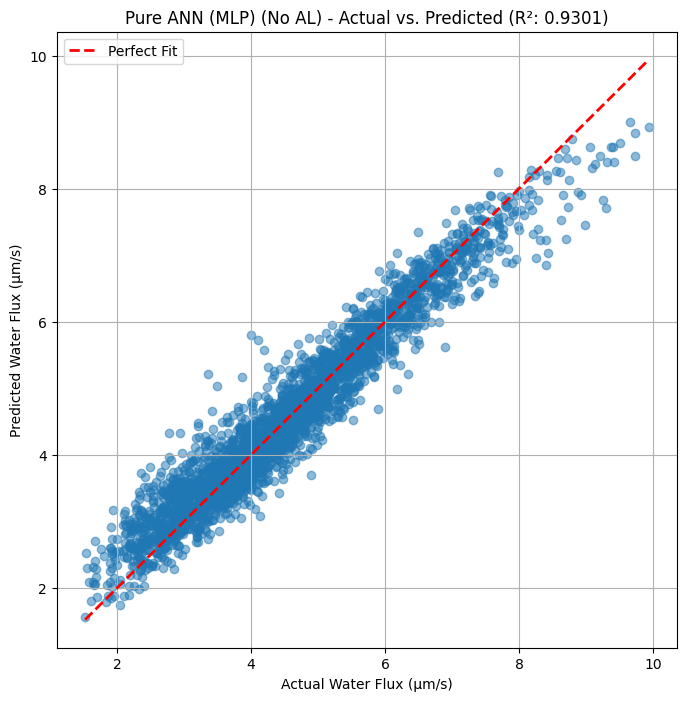

In [7]:
#Direct ANN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import warnings

# --- Set global seed and test set size ---
GLOBAL_RANDOM_SEED = 42
TEST_SET_FRACTION = 0.95


# --- Custom Error Metric ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Main Execution (ANN Only) ---
if __name__ == "__main__":
    np.random.seed(GLOBAL_RANDOM_SEED)
    warnings.filterwarnings('ignore', category=Warning, module='sklearn')

    # Load and preprocess data
    df = pd.read_csv("results_final.csv")
    if df.columns[0].startswith('Unnamed') or df.columns[0] == 'idx':
        df = df.iloc[:, 1:]

    # Convert units
    df['Lx (m)'] = df['Lx (mm)'] / 1000
    df['t_c (m)'] = df['t_c (mm)'] / 1000
    df['t_psl (m)'] = df['t_psl (um)'] / 1e6
    df['Water flux (m/s)'] = df['Water flux (um/s)'] / 1e6

    # Define features and target
    features = ['cf_in (M)', 'cd_in (M)', 'Lx (m)', 'uf_in (m/s)', 'ud_in (m/s)',
                't_c (m)', 't_psl (m)', 'eps_psl', 'tau', 'A (m/Pa/s)']

    X = df[features].values
    y = df['Water flux (m/s)'].values.reshape(-1, 1)

    # Create the fixed test set (y is now 2D)
    X_main, X_test, y_main, y_test = train_test_split(
        X, y,
        test_size=TEST_SET_FRACTION,
        random_state=GLOBAL_RANDOM_SEED
    )


    all_main_indices = np.arange(len(X_main))
    train_indices = np.random.choice(all_main_indices, size=len(X_main), replace=False)

    X_train = X_main[train_indices]
    y_train = y_main[train_indices]

    print(f"\nTraining Pure ANN (MLP) on {len(y_train)} random points.")
    print(f"Testing on fixed test set of {len(y_test)} points.")


    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)


    # Define and train ANN
    ann = MLPRegressor(
        hidden_layer_sizes=(50, 25),
        activation='relu',
        solver='adam',
        max_iter=2000,
        random_state=GLOBAL_RANDOM_SEED,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.15
    )

    print("Fitting ANN (MLP) model on SCALED y...")

    ann.fit(X_train_scaled, y_train_scaled.ravel())

    # Evaluate
    print("Evaluating model...")

    y_pred_scaled = ann.predict(X_test_scaled)


    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))


    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print("\n--- Pure ANN (MLP) Only (No AL) Performance ---")
    print(f"Training size: {len(y_train)}")
    print(f"Test size: {len(y_test)}")
    print(f"MAE: {mae:.3e} m/s  ({mae*1e6:.3f} µm/s)")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # Save model and scalers
    joblib.dump(ann, 'pure_ann_simple_model.joblib')
    joblib.dump(x_scaler, 'pure_x_scaler_simple.joblib')
    joblib.dump(y_scaler, 'pure_y_scaler_simple.joblib')
    print("\nSaved 'pure_ann_simple_model.joblib' and scalers.")

    # --- Visualization (Actual vs. Predicted on Test Set) ---
    plt.figure(figsize=(8, 8))
    # Plot y_test (original) vs y_pred (inversed)
    plt.scatter(y_test*1e6, y_pred*1e6, alpha=0.5)
    plt.plot([y_test.min()*1e6, y_test.max()*1e6], [y_test.min()*1e6, y_test.max()*1e6], 'r--', lw=2, label="Perfect Fit")
    plt.xlabel("Actual Water Flux (µm/s)")
    plt.ylabel("Predicted Water Flux (µm/s)")
    plt.title(f"Pure ANN (MLP) (No AL) - Actual vs. Predicted (R²: {r2:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

Solving physics model...


100%|██████████| 3004/3004 [00:01<00:00, 1618.40it/s]



Splitting data into training and test sets...
Total data: 3004, Training: 150, Test: 2854
Training ANN (MLPRegressor) model on *scaled* residuals...
ANN model training complete.
Evaluating model on test set...

--- Final Hybrid Model Performance ---
MAE: 1.986e-01 m/s  (or 198630.104 µm/s)
R²: 0.9693
MAPE: 5.14%

Saved ANN model to 'ann_residual_model.joblib'
Saved input scaler to 'x_scaler.joblib'
Saved target scaler to 'y_scaler.joblib'


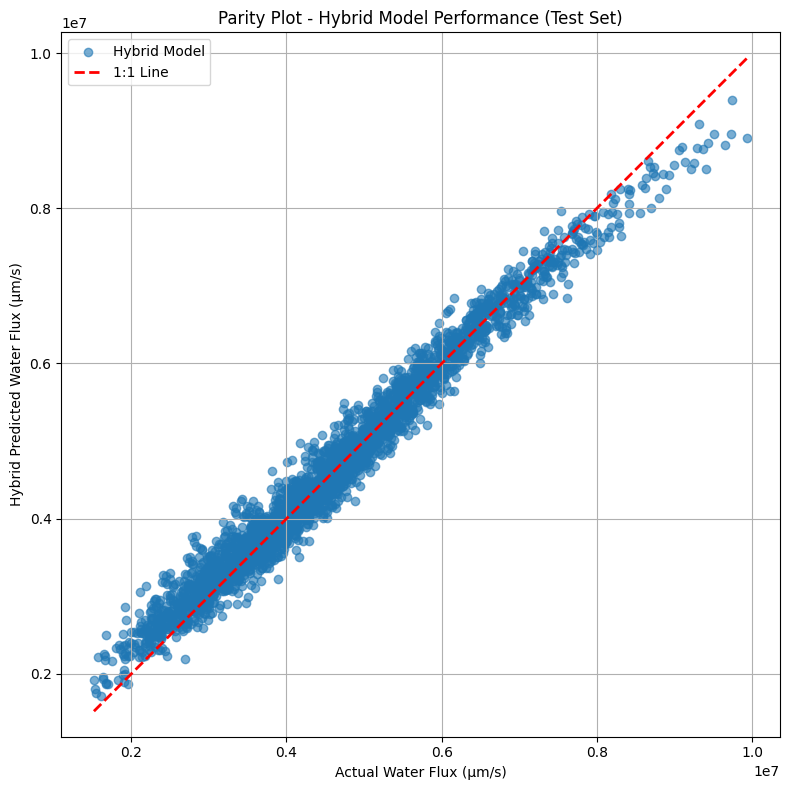

In [8]:

# --- Hybrid ANN ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# --- 1. Physical Property Functions ---
def calculate_rho(c):
    return 995.7 + 39.92 * c - 1.235 * c**2

def calculate_mu(c):
    return 7.98e-4 + 7.53e-5 * c + 1.037e-5 * c**2 - 8.81e-8 * c**3

def calculate_D(c):
    return np.where(c < 0.5,
                    1.71e-9 * (1 - 1.099*c + 8.129*c**2 - 31.6*c**3 + 57.5*c**4 - 39.4*c**5),
                    1.71e-9 * (1 - 0.0778*c + 0.0039*c**2))

def calculate_pi(c):
    pi_bar = 9.5508 * c**2 + 32.895 * c + 0.5081
    return pi_bar * 100000.0

def calculate_dh(t_c):
    w = 0.1
    h = t_c
    return (2.0 * w * h) / (w + h)

# --- 2. Physical Model Solver ---
def solve_forward_osmosis(df):
    B = 7.25e-8
    epsilon = 1e-12
    cf, cd, Lx, u_feed, u_draw, t_c, t_psl, eps_psl, tau, A = (
        df['cf_in (M)'], df['cd_in (M)'], df['Lx (m)'], df['uf_in (m/s)'], df['ud_in (m/s)'],
        df['t_c (m)'], df['t_psl (m)'], df['eps_psl'], df['tau'], df['A (m/Pa/s)']
    )
    S = t_psl * tau / (eps_psl + epsilon)
    d_h = calculate_dh(t_c)
    pi_f = calculate_pi(cf); pi_d = calculate_pi(cd); D_d = calculate_D(cd)
    rho_f = calculate_rho(cf); mu_f = calculate_mu(cf); D_f = calculate_D(cf)
    Re_f = rho_f * u_feed * d_h / (mu_f + epsilon); Sc_f = mu_f / (rho_f * D_f + epsilon)
    sh_base_f = np.maximum(Re_f * Sc_f * d_h / (Lx + epsilon), 0.0)
    Sh_f = 1.85 * sh_base_f**0.33; k_f = Sh_f * D_f / (d_h + epsilon)
    rho_d = calculate_rho(cd); mu_d = calculate_mu(cd)
    Re_d = rho_d * u_draw * d_h / (mu_d + epsilon); Sc_d = mu_d / (rho_d * D_d + epsilon)
    sh_base_d = np.maximum(Re_d * Sc_d * d_h / (Lx + epsilon), 0.0)
    Sh_d = 1.85 * sh_base_d**0.33; k_d = Sh_d * D_d / (d_h + epsilon)

    jw_solved_list = []
    print("Solving physics model...")
    for i in tqdm(range(len(df))):
        def objective_function(jw):
            jw = jw + epsilon
            exp_term_draw = np.exp(-jw * (1.0/(k_d[i] + epsilon) + S[i]/(D_d[i] + epsilon)))
            exp_term_feed = np.exp(jw / (k_f[i] + epsilon))
            numerator = pi_d[i] * exp_term_draw - pi_f[i] * exp_term_feed
            denominator = 1.0 + (B / jw) * (exp_term_feed - exp_term_draw)
            jw_rhs = A[i] * (numerator / (denominator + epsilon))
            return jw - jw_rhs
        try:
            jw_solution = brentq(objective_function, 1e-8, 1e-4)
            jw_solved_list.append(jw_solution)
        except ValueError:
            jw_solved_list.append(np.nan)
    return np.array(jw_solved_list)

# --- 3. Custom Error Metric ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- 4. Main Execution ---
if __name__ == "__main__":
    # Load and preprocess data
    df = pd.read_csv("results_final.csv")
    if df.columns[0].startswith('Unnamed') or df.columns[0] == 'idx':
        df = df.iloc[:, 1:]

    df['Lx (m)'] = df['Lx (mm)'] / 1000
    df['t_c (m)'] = df['t_c (mm)'] / 1000
    df['t_psl (m)'] = df['t_psl (um)'] / 1e6

    if 'Water flux (um/s)' in df.columns:
        df.rename(columns={'Water flux (um/s)': 'Water flux (m/s)'}, inplace=True)


    # Run physics model
    jw_physical = solve_forward_osmosis(df)
    df['jw_physical'] = jw_physical
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Features & targets
    features = ['cf_in (M)', 'cd_in (M)', 'Lx (m)', 'uf_in (m/s)', 'ud_in (m/s)',
                't_c (m)', 't_psl (m)', 'eps_psl', 'tau', 'A (m/Pa/s)', 'jw_physical']
    X = df[features].values
    y_actual = df['Water flux (m/s)'].values
    y_residual = y_actual - df['jw_physical'].values

    # --- Standard Train-Test Split ---
    print("\nSplitting data into training and test sets...")

    indices = np.arange(len(df))
    train_indices, test_indices = train_test_split(indices, test_size=0.95, random_state=42)

    X_train = X[train_indices]
    X_test = X[test_indices]

    y_residual_train = y_residual[train_indices]
    y_residual_test = y_residual[test_indices]

    y_actual_test = y_actual[test_indices]
    jw_physical_test = df['jw_physical'].iloc[test_indices].values

    print(f"Total data: {len(df)}, Training: {len(X_train)}, Test: {len(X_test)}")


    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)

    # Fit the y_scaler on the training residuals and transform them
    y_residual_train_scaled = y_scaler.fit_transform(y_residual_train.reshape(-1, 1))


    # --- Train ANN Model on Scaled Residuals ---
    print("Training ANN (MLPRegressor) model on *scaled* residuals...")

    ann = MLPRegressor(
        hidden_layer_sizes=(50, 25),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        verbose=False
    )

    # Fit on scaled inputs and scaled targets
    ann.fit(X_train_scaled, y_residual_train_scaled.ravel())
    print("ANN model training complete.")

    # --- Evaluate on Test Set ---
    print("Evaluating model on test set...")


    # 1. Predict the *scaled* residual
    error_pred_scaled = ann.predict(X_test_scaled)

    # 2. Inverse-transform the prediction to get the *true* residual
    error_pred = y_scaler.inverse_transform(error_pred_scaled.reshape(-1, 1)).ravel()

    # Final prediction is the physics model + ANN's *unscaled* predicted residual
    hybrid_pred = jw_physical_test + error_pred

    mae = mean_absolute_error(y_actual_test, hybrid_pred)
    r2 = r2_score(y_actual_test, hybrid_pred)
    mape = mean_absolute_percentage_error(y_actual_test, hybrid_pred)

    print("\n--- Final Hybrid Model Performance ---")
    print(f"MAE: {mae:.3e} m/s  (or {mae*1e6:.3f} µm/s)")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # --- Save Model ---
    joblib.dump(ann, 'ann_residual_model.joblib')
    joblib.dump(x_scaler, 'x_scaler.joblib')
    joblib.dump(y_scaler, 'y_scaler.joblib')
    print("\nSaved ANN model to 'ann_residual_model.joblib'")
    print("Saved input scaler to 'x_scaler.joblib'")
    print("Saved target scaler to 'y_scaler.joblib'")


    # --- Visualization (Parity Plot) ---
    plt.figure(figsize=(8, 8))

    y_actual_plot = y_actual_test * 1e6
    hybrid_pred_plot = hybrid_pred * 1e6

    plt.scatter(y_actual_plot, hybrid_pred_plot, alpha=0.6, label='Hybrid Model')
    lim_min = np.min([y_actual_plot.min(), hybrid_pred_plot.min()])
    lim_max = np.max([y_actual_plot.max(), hybrid_pred_plot.max()])
    plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2, label='1:1 Line')

    plt.xlabel("Actual Water Flux (µm/s)")
    plt.ylabel("Hybrid Predicted Water Flux (µm/s)")
    plt.title("Parity Plot - Hybrid Model Performance (Test Set)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



Feature means (SI): [2.39333333e-01 2.33733333e+00 1.91779667e-01 1.22993333e-01
 1.24053333e-01 5.46506667e-03 7.24072667e-05 5.12000000e-01
 1.81240000e+00 3.29733333e-12]
Feature stds (SI): [1.30642855e-01 3.65886443e-01 7.16829696e-02 9.56207555e-03
 1.02024746e-02 1.31544707e-03 2.17862574e-05 1.11845131e-01
 3.42209838e-01 1.65376123e-12]
Sigma_z (std-space) diag: [0.00134244 0.01632333 0.01789424 0.26471514 0.23655156 0.04315034
 0.07069342 0.20955873 0.10097774 0.00993848]
MAPE: 1.2083e+00 (target in m/s)
NLPD: -1.3866e+01
Gradient norms (z-space): mean 1.491e-06, max 3.465e-06

Variance summary:
mean GPR var: 3.5441080491717334e-15 mean input var: 1.5347184448100502e-13 mean total var: 1.5701595253017675e-13
Non-positive total_var count: 0

Top 5 residual indices: [1097 2655 1798 1402 1713]

Sample 1097: resid=6.174e-07, input_var=3.140e-13
  cf_in (M): 1.836e-15
  cd_in (M): 7.447e-15
  Lx (mm): 2.319e-15
  uf_in (m/s): 6.758e-17
  ud_in (m/s): 2.841e-15
  t_c (mm): 8.576e-16

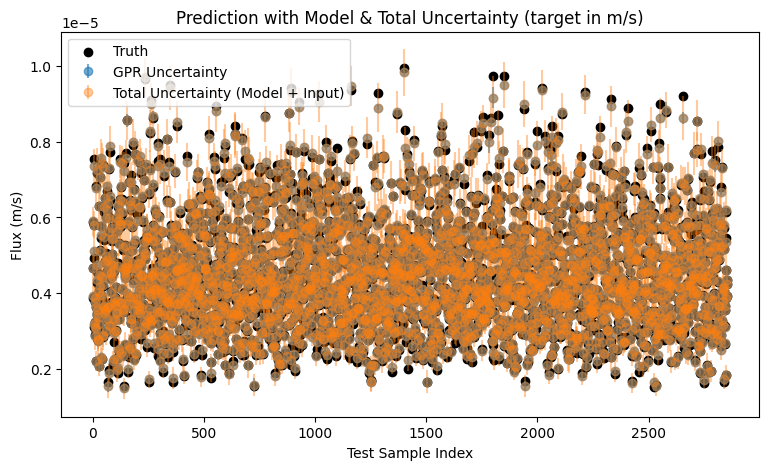

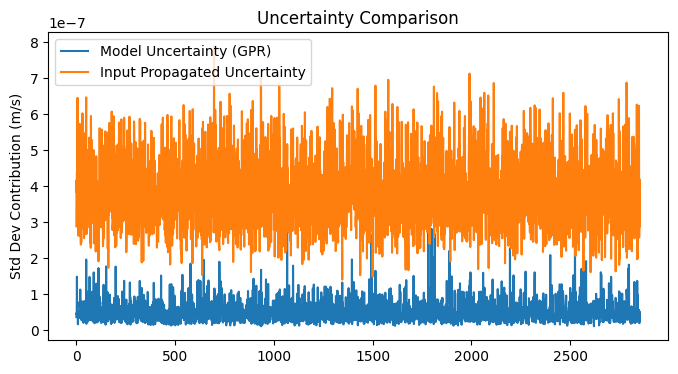

In [9]:
#robust GPR

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


csv_path = "/content/results_final.csv"
features = ['cf_in (M)', 'cd_in (M)', 'Lx (mm)', 'uf_in (m/s)', 'ud_in (m/s)',
            't_c (mm)', 't_psl (um)', 'eps_psl', 'tau', 'A (m/Pa/s)']
target_col = 'Water flux (um/s)'


df = pd.read_csv(csv_path)
X = df[features].astype(float).values.copy()
y = df[target_col].astype(float).values.copy()


# UNIT CONVERSION

idx_Lx   = features.index('Lx (mm)')
idx_tc   = features.index('t_c (mm)')
idx_tpsl = features.index('t_psl (um)')

X[:, idx_Lx]   *= 1e-3
X[:, idx_tc]   *= 1e-3
X[:, idx_tpsl] *= 1e-6
y = y * 1e-6


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.95, random_state=42)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z  = scaler.transform(X_test)

mu_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
print("Feature means (SI):", mu_train)
print("Feature stds (SI):", std_train)

# ============================
# SCIENTIFICALLY BASED CV VALUES (MATCHING FEATURE ORDER)
# ============================
percent_uncertainty = np.array([
    0.02,  # cf_in (M)
    0.02,  # cd_in (M)
    0.05,  # Lx
    0.04,  # uf_in
    0.04,  # ud_in
    0.05,  # t_c
    0.08,  # t_psl
    0.10,  # eps_psl
    0.06,  # tau
    0.05   # A
])

# Build Sigma in standardized (z) space:
# sigma_z_i = CV_i * (mu_train_i / std_train_i)
# If std_train_i == 0 (rare), set a small floor to avoid div-by-zero
std_floor = 1e-12
std_train_safe = np.where(std_train < std_floor, std_floor, std_train)
sigma_z_vec = percent_uncertainty * (mu_train / std_train_safe)
D_z = np.diag(sigma_z_vec)

# Correlation matrix
m = len(features)
Corr = np.eye(m)
Corr[7,9] = Corr[9,7] = 0.70
Corr[7,8] = Corr[8,7] = -0.60
Corr[9,8] = Corr[8,9] = -0.50
Corr[5,6] = Corr[6,5] = 0.30
Corr[3,4] = Corr[4,3] = 0.50
Corr[5,9] = Corr[9,5] = -0.40

# Sigma in z-space
Sigma_z = D_z @ Corr @ D_z
Sigma_z = 0.5 * (Sigma_z + Sigma_z.T)
eigvals, eigvecs = np.linalg.eigh(Sigma_z)
if eigvals.min() < 1e-12:
    eigvals_clipped = np.clip(eigvals, 1e-12, None)
    Sigma_z = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

print("Sigma_z (std-space) diag:", np.diag(Sigma_z))

# TRAIN GPR
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X_train_z.shape[1]))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, normalize_y=True, n_restarts_optimizer=8)
gpr.fit(X_train_z, y_train)

y_mean, y_std_gpr = gpr.predict(X_test_z, return_std=True)
y_var_gpr = y_std_gpr**2

# ============================
# NUMERICAL GRADIENT (in z-space) with RELATIVE eps
# ============================
def compute_gradients_z(model, xz, rel_eps=1e-3, abs_floor=1e-6):
    # xz: standardized input vector (z-space)
    d = len(xz)
    grad = np.zeros(d)
    for i in range(d):
        # eps scaled to feature scale in z-space
        eps = rel_eps * max(abs(xz[i]), abs_floor)
        x1 = xz.copy(); x2 = xz.copy()
        x1[i] += eps; x2[i] -= eps
        # predict returns scalar
        f1 = model.predict(x1.reshape(1, -1))[0]
        f2 = model.predict(x2.reshape(1, -1))[0]
        grad[i] = (f1 - f2) / (2 * eps)
    return grad

# compute input_var in z-space (use gradients w.r.t z)
input_var = []
grad_norms = []
for xz in X_test_z:
    g = compute_gradients_z(gpr, xz, rel_eps=1e-3, abs_floor=1e-6)
    grad_norms.append(np.linalg.norm(g))
    v = g.T @ Sigma_z @ g
    input_var.append(v)
input_var = np.array(input_var)

# ============================
# TOTAL UNCERTAINTY & METRICS
# ============================
total_var = y_var_gpr + input_var
total_std = np.sqrt(total_var)

def nlpd(y_true, mean, var):
    return 0.5 * np.mean(np.log(2 * np.pi * var) + (y_true - mean)**2 / var)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(y_test, y_mean)
nlpd_value = nlpd(y_test, y_mean, total_var)

print(f"MAPE: {MAPE:.4e} (target in m/s)")
print(f"NLPD: {nlpd_value:.4e}")
print("Gradient norms (z-space): mean {:.3e}, max {:.3e}".format(np.mean(grad_norms), np.max(grad_norms)))

# DIAGNOSTICS
print("\nVariance summary:")
print("mean GPR var:", y_var_gpr.mean(), "mean input var:", input_var.mean(), "mean total var:", total_var.mean())
print("Non-positive total_var count:", np.sum(total_var <= 0))

# Identify worst residuals and show per-feature contribution
resid = np.abs(y_test - y_mean)
worst_idx = np.argsort(resid)[-5:][::-1]
print("\nTop 5 residual indices:", worst_idx)

def per_feature_contrib(g, Sigma):
    m = len(g)
    contrib = np.zeros(m)
    for i in range(m):
        contrib[i] += g[i] * Sigma[i, i] * g[i]
        for j in range(i+1, m):
            cross = g[i] * Sigma[i, j] * g[j]
            contrib[i] += 0.5 * cross
            contrib[j] += 0.5 * cross
    return contrib

for i in worst_idx:
    g = compute_gradients_z(gpr, X_test_z[i], rel_eps=1e-3)
    contr = per_feature_contrib(g, Sigma_z)
    print(f"\nSample {i}: resid={y_test[i]-y_mean[i]:.3e}, input_var={input_var[i]:.3e}")
    for name, c in zip(features, contr):
        print(f"  {name}: {c:.3e}")
    print(" sum contrib:", contr.sum())


plt.figure(figsize=(9,5))
plt.errorbar(range(len(y_test)), y_mean, yerr=np.sqrt(y_var_gpr),
             fmt='o', alpha=0.6, label="GPR Uncertainty")
plt.errorbar(range(len(y_test)), y_mean, yerr=total_std,
             fmt='o', alpha=0.4, label="Total Uncertainty (Model + Input)")
plt.scatter(range(len(y_test)), y_test, label="Truth", color="black")
plt.title("Prediction with Model & Total Uncertainty (target in m/s)")
plt.legend()
plt.xlabel("Test Sample Index")
plt.ylabel("Flux (m/s)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(y_var_gpr), label="Model Uncertainty (GPR)")
plt.plot(np.sqrt(input_var), label="Input Propagated Uncertainty")
plt.title("Uncertainty Comparison")
plt.ylabel("Std Dev Contribution (m/s)")
plt.legend()
plt.show()


Running Monte Carlo validation on 50 test points...
Sampling 1000 perturbed inputs per point...

MONTE CARLO VALIDATION RESULTS
Mean absolute relative error: 0.0041 (0.41%)
Correlation (analytical vs MC): 0.9960
RMSE in std dev space: 8.263086e-09

Mean MC variance:         1.578238e-13
Mean Analytical variance: 1.571861e-13


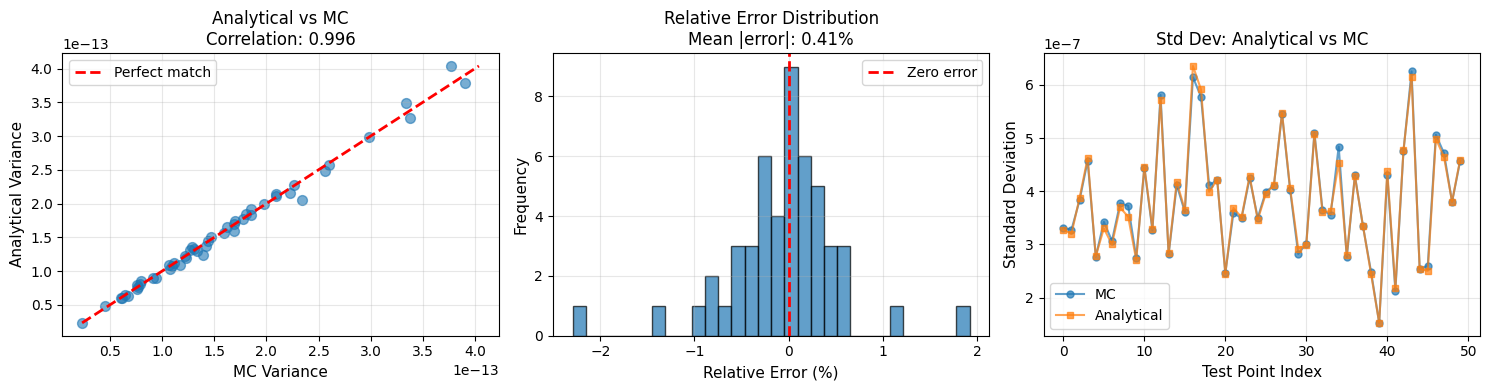


ASSESSMENT:
 EXCELLENT: Analytical propagation matches MC very well (<10% error)
 Strong correlation - relative magnitudes are correct

CHECKING WORST MATCHES:
Test point 34: MC=2.3407e-13, Analytical=2.0578e-13, Error=-12.08%
Test point 16: MC=3.7730e-13, Analytical=4.0377e-13, Error=7.02%
Test point 17: MC=3.3356e-13, Analytical=3.4957e-13, Error=4.80%
Test point 8: MC=1.3891e-13, Analytical=1.2400e-13, Error=-10.74%
Test point 43: MC=3.9085e-13, Analytical=3.7848e-13, Error=-3.16%


In [10]:

# MONTE CARLO VALIDATION OF INPUT UNCERTAINTY PROPAGATION

import numpy as np
import matplotlib.pyplot as plt

def validate_uncertainty_propagation_mc(gpr, X_test_z, Sigma_z, input_var_analytical,
                                        n_samples=1000, n_test_points=50):

    n_total = len(X_test_z)
    if n_total > n_test_points:
        test_indices = np.random.choice(n_total, n_test_points, replace=False)
    else:
        test_indices = np.arange(n_total)

    input_var_mc = []
    input_var_analyt = []

    print(f"Running Monte Carlo validation on {len(test_indices)} test points...")
    print(f"Sampling {n_samples} perturbed inputs per point...")

    for idx in test_indices:
        x_nominal = X_test_z[idx]  # Nominal point in z-space

        # Monte Carlo: Sample perturbed inputs from N(x_nominal, Sigma_z)
        x_samples = np.random.multivariate_normal(x_nominal, Sigma_z, size=n_samples)

        # Predict output for all samples
        y_samples = gpr.predict(x_samples)

        # Empirical variance from MC samples
        var_mc = np.var(y_samples, ddof=1)
        input_var_mc.append(var_mc)

        # analytical estimate
        input_var_analyt.append(input_var_analytical[idx])

    input_var_mc = np.array(input_var_mc)
    input_var_analyt = np.array(input_var_analyt)

    # Validation metrics
    relative_error = (input_var_analyt - input_var_mc) / (input_var_mc + 1e-12)
    mean_rel_error = np.mean(np.abs(relative_error))

    # Correlation between analytical and MC
    correlation = np.corrcoef(input_var_analyt, input_var_mc)[0, 1]

    # RMSE in standard deviation space (more interpretable)
    rmse_std = np.sqrt(np.mean((np.sqrt(input_var_analyt) - np.sqrt(input_var_mc))**2))

    print("\n" + "="*70)
    print("MONTE CARLO VALIDATION RESULTS")
    print("="*70)
    print(f"Mean absolute relative error: {mean_rel_error:.4f} ({mean_rel_error*100:.2f}%)")
    print(f"Correlation (analytical vs MC): {correlation:.4f}")
    print(f"RMSE in std dev space: {rmse_std:.6e}")
    print(f"\nMean MC variance:         {input_var_mc.mean():.6e}")
    print(f"Mean Analytical variance: {input_var_analyt.mean():.6e}")
    print("="*70)

    # Visual validation
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Scatter plot: Analytical vs MC
    axes[0].scatter(input_var_mc, input_var_analyt, alpha=0.6, s=50)
    min_val = min(input_var_mc.min(), input_var_analyt.min())
    max_val = max(input_var_mc.max(), input_var_analyt.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect match')
    axes[0].set_xlabel('MC Variance', fontsize=11)
    axes[0].set_ylabel('Analytical Variance', fontsize=11)
    axes[0].set_title(f'Analytical vs MC\nCorrelation: {correlation:.3f}', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Relative error distribution
    axes[1].hist(relative_error * 100, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    axes[1].set_xlabel('Relative Error (%)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title(f'Relative Error Distribution\nMean |error|: {mean_rel_error*100:.2f}%',
                     fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. Standard deviation comparison
    std_mc = np.sqrt(input_var_mc)
    std_analyt = np.sqrt(input_var_analyt)
    x_points = np.arange(len(test_indices))
    axes[2].plot(x_points, std_mc, 'o-', label='MC', alpha=0.7, markersize=5)
    axes[2].plot(x_points, std_analyt, 's-', label='Analytical', alpha=0.7, markersize=5)
    axes[2].set_xlabel('Test Point Index', fontsize=11)
    axes[2].set_ylabel('Standard Deviation', fontsize=11)
    axes[2].set_title('Std Dev: Analytical vs MC', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Assessment
    print("\nASSESSMENT:")
    if mean_rel_error < 0.1:
        print(" EXCELLENT: Analytical propagation matches MC very well (<10% error)")
    elif mean_rel_error < 0.2:
        print(" GOOD: Analytical propagation reasonably accurate (<20% error)")
    elif mean_rel_error < 0.3:
        print("ACCEPTABLE: Moderate discrepancy (20-30% error) - check gradients")
    else:
        print("POOR: Large discrepancy (>30% error) - verify gradient computation or Sigma_z")

    if correlation > 0.9:
        print(" Strong correlation - relative magnitudes are correct")
    elif correlation > 0.7:
        print("Moderate correlation - some systematic bias may exist")
    else:
        print(" Weak correlation - fundamental issue with propagation")

    return {
        'input_var_mc': input_var_mc,
        'input_var_analytical': input_var_analyt,
        'mean_rel_error': mean_rel_error,
        'correlation': correlation,
        'rmse_std': rmse_std,
        'test_indices': test_indices
    }


np.random.seed(42)

# Run Monte Carlo validation
validation_results = validate_uncertainty_propagation_mc(
    gpr=gpr,
    X_test_z=X_test_z,
    Sigma_z=Sigma_z,
    input_var_analytical=input_var,
    n_samples=1000,      # More samples = more accurate MC estimate
    n_test_points=50     # Validate on subset for speed
)

print("\n" + "="*70)
print("CHECKING WORST MATCHES:")
print("="*70)
idx_worst = np.argsort(np.abs(validation_results['input_var_analytical'] -
                               validation_results['input_var_mc']))[-5:][::-1]

for i in idx_worst:
    mc_val = validation_results['input_var_mc'][i]
    analyt_val = validation_results['input_var_analytical'][i]
    rel_err = (analyt_val - mc_val) / mc_val * 100
    print(f"Test point {i}: MC={mc_val:.4e}, Analytical={analyt_val:.4e}, Error={rel_err:.2f}%")

Computing physics model predictions...
Valid samples: 3004
Training samples: 150, Test samples: 2854
Feature means (SI): [2.39333333e-01 2.33733333e+00 1.91779667e-01 1.22993333e-01
 1.24053333e-01 5.46506667e-03 7.24072667e-05 5.12000000e-01
 1.81240000e+00 3.29733333e-12]
Feature stds (SI): [1.30642855e-01 3.65886443e-01 7.16829696e-02 9.56207555e-03
 1.02024746e-02 1.31544707e-03 2.17862574e-05 1.11845131e-01
 3.42209838e-01 1.65376123e-12]
Sigma_z (std-space) diag: [0.00134244 0.01632333 0.01789424 0.26471514 0.23655156 0.04315034
 0.07069342 0.20955873 0.10097774 0.00993848]

Training GPR on residuals...
GPR trained on residuals.
Optimized kernel: 3.32**2 * RBF(length_scale=[7.25, 8, 6.53, 1.23e+03, 33.2, 4.95, 5.07, 10, 11.1, 2.53]) + WhiteKernel(noise_level=0.000787)

Computing gradients and input uncertainty...


100%|██████████| 2854/2854 [00:42<00:00, 67.63it/s]



HYBRID MODEL PERFORMANCE
RMSE: 1.6507e-08 m/s (0.0165 µm/s)
MAPE: 0.26%
NLPD: -1.3866e+01
Gradient norms (z-space): mean 1.618e-06, max 1.099e-05

UNCERTAINTY DIAGNOSTICS
Mean GPR var:    1.578e-16
Mean input var:  1.662e-13
Mean total var:  1.664e-13
Non-positive total_var count: 0

TOP 5 RESIDUAL ANALYSIS

#1 - Sample 1798:
  Actual: 9.7385 µm/s, Predicted: 9.9316 µm/s
  Residual: -0.1930 µm/s
  Input variance: 6.092e-13
  Feature contributions to input variance:
    cf_in (M)           : 3.373e-15
    cd_in (M)           : 6.419e-15
    Lx (mm)             : 1.837e-14
    uf_in (m/s)         : 5.317e-16
    ud_in (m/s)         : 2.505e-15
    t_c (mm)            : 2.144e-14
    t_psl (um)          : 3.342e-13
    eps_psl             : 9.629e-14
    tau                 : 4.632e-14
    A (m/Pa/s)          : 1.339e-14

#2 - Sample 1782:
  Actual: 8.1811 µm/s, Predicted: 8.3345 µm/s
  Residual: -0.1533 µm/s
  Input variance: 3.703e-13
  Feature contributions to input variance:
    cf_i

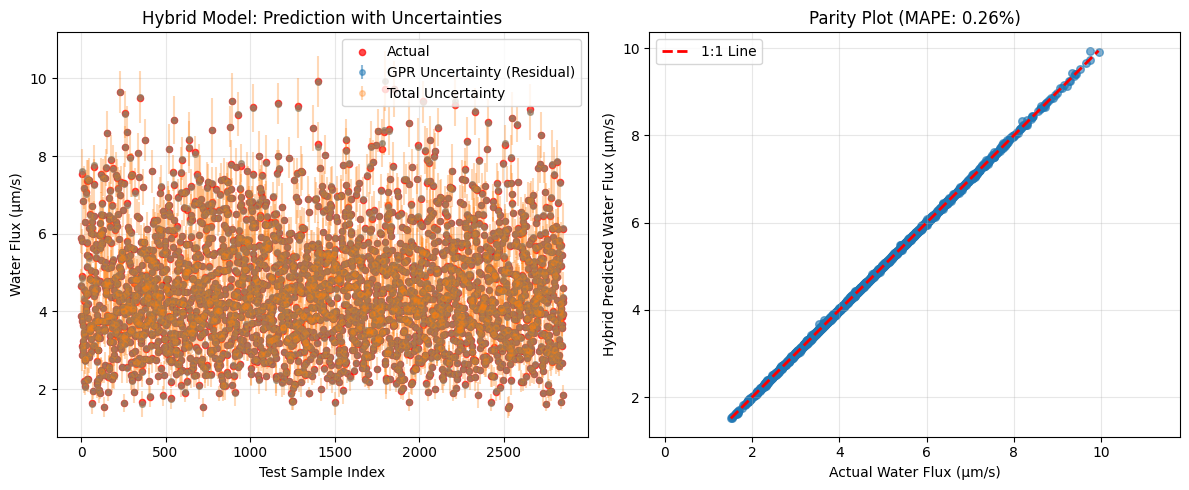

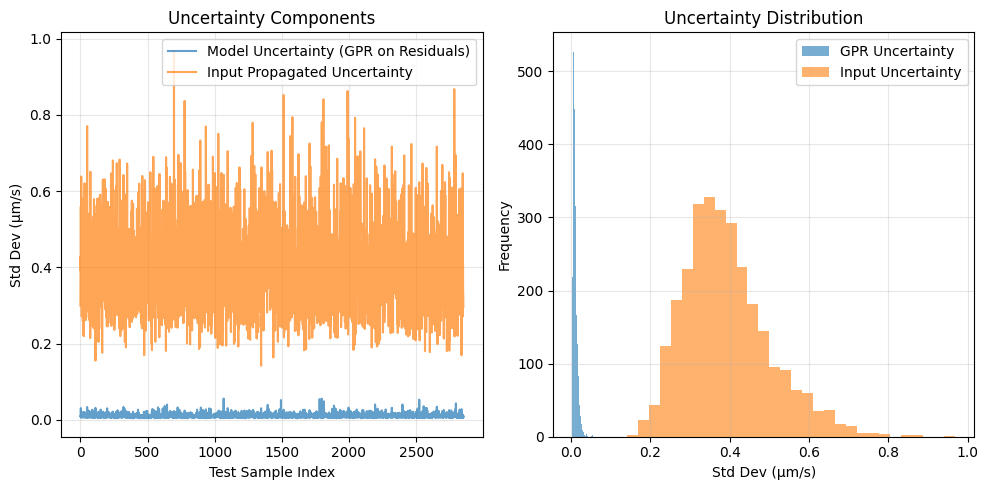

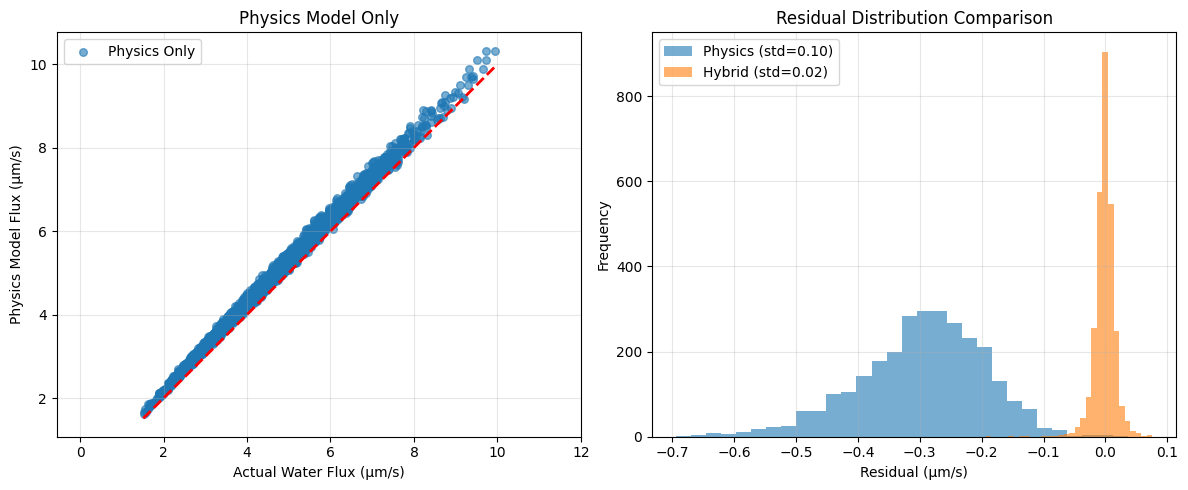


Analysis complete!


In [11]:
#Hybrid Robust GPR

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from tqdm import tqdm

# PHYSICAL PROPERTY FUNCTIONS
def calculate_rho(c):
    return 995.7 + 39.92 * c - 1.235 * c**2

def calculate_mu(c):
    return 7.98e-4 + 7.53e-5 * c + 1.037e-5 * c**2 - 8.81e-8 * c**3

def calculate_D(c):
    return np.where(c < 0.5,
                    1.71e-9 * (1 - 1.099*c + 8.129*c**2 - 31.6*c**3 + 57.5*c**4 - 39.4*c**5),
                    1.71e-9 * (1 - 0.0778*c + 0.0039*c**2))

def calculate_pi(c):
    pi_bar = 9.5508 * c**2 + 32.895 * c + 0.5081
    return pi_bar * 100000.0

def calculate_dh(t_c):
    w = 0.1
    h = t_c
    return (2.0 * w * h) / (w + h)

# PHYSICS MODEL SOLVER
def solve_forward_osmosis_single(cf, cd, Lx, u_feed, u_draw, t_c, t_psl, eps_psl, tau, A):
    """Solve physics model for a single data point"""
    B = 7.25e-8
    epsilon = 1e-12

    S = t_psl * tau / (eps_psl + epsilon)
    d_h = calculate_dh(t_c)

    pi_f = calculate_pi(cf)
    pi_d = calculate_pi(cd)
    D_d = calculate_D(cd)

    rho_f = calculate_rho(cf)
    mu_f = calculate_mu(cf)
    D_f = calculate_D(cf)

    Re_f = rho_f * u_feed * d_h / (mu_f + epsilon)
    Sc_f = mu_f / (rho_f * D_f + epsilon)
    sh_base_f = np.maximum(Re_f * Sc_f * d_h / (Lx + epsilon), 0.0)
    Sh_f = 1.85 * sh_base_f**0.33
    k_f = Sh_f * D_f / (d_h + epsilon)

    rho_d = calculate_rho(cd)
    mu_d = calculate_mu(cd)
    Re_d = rho_d * u_draw * d_h / (mu_d + epsilon)
    Sc_d = mu_d / (rho_d * D_d + epsilon)
    sh_base_d = np.maximum(Re_d * Sc_d * d_h / (Lx + epsilon), 0.0)
    Sh_d = 1.85 * sh_base_d**0.33
    k_d = Sh_d * D_d / (d_h + epsilon)

    def objective_function(jw):
        jw = jw + epsilon
        exp_term_draw = np.exp(-jw * (1.0/(k_d + epsilon) + S/(D_d + epsilon)))
        exp_term_feed = np.exp(jw / (k_f + epsilon))
        numerator = pi_d * exp_term_draw - pi_f * exp_term_feed
        denominator = 1.0 + (B / jw) * (exp_term_feed - exp_term_draw)
        jw_rhs = A * (numerator / (denominator + epsilon))
        return jw - jw_rhs

    try:
        jw_solution = brentq(objective_function, 1e-8, 1e-4)
        return jw_solution
    except ValueError:
        return np.nan

def solve_forward_osmosis_batch(X_original):
    """Solve physics model for batch of data points
    X_original: (n_samples, 10) in SI units [cf, cd, Lx, uf, ud, tc, tpsl, eps, tau, A]
    """
    jw_list = []
    for i in range(len(X_original)):
        cf, cd, Lx, u_feed, u_draw, t_c, t_psl, eps_psl, tau, A = X_original[i]
        jw = solve_forward_osmosis_single(cf, cd, Lx, u_feed, u_draw, t_c, t_psl, eps_psl, tau, A)
        jw_list.append(jw)
    return np.array(jw_list)

# USER INPUTS
csv_path = "results_final.csv"
features = ['cf_in (M)', 'cd_in (M)', 'Lx (mm)', 'uf_in (m/s)', 'ud_in (m/s)',
            't_c (mm)', 't_psl (um)', 'eps_psl', 'tau', 'A (m/Pa/s)']
target_col = 'Water flux (um/s)'



df = pd.read_csv(csv_path)
X = df[features].astype(float).values.copy()
y = df[target_col].astype(float).values.copy()


# UNIT CONVERSION → SI (inputs)

idx_Lx = features.index('Lx (mm)')
idx_tc = features.index('t_c (mm)')
idx_tpsl = features.index('t_psl (um)')

X[:, idx_Lx] *= 1e-3   # mm -> m
X[:, idx_tc] *= 1e-3   # mm -> m
X[:, idx_tpsl] *= 1e-6 # um -> m

# Convert target to SI: um/s -> m/s
y = y * 1e-6


# COMPUTE PHYSICS MODEL PREDICTIONS
print("Computing physics model predictions...")
jw_physical = solve_forward_osmosis_batch(X)

valid_mask = ~np.isnan(jw_physical)
X = X[valid_mask]
y = y[valid_mask]
jw_physical = jw_physical[valid_mask]

print(f"Valid samples: {len(X)}")

# Compute residuals
y_residual = y - jw_physical


X_train, X_test, y_train, y_test, jw_phys_train, jw_phys_test, y_res_train, y_res_test = train_test_split(
    X, y, jw_physical, y_residual, test_size=0.95, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

mu_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

print("Feature means (SI):", mu_train)
print("Feature stds (SI):", std_train)

# ============================
# UNCERTAINTY COVARIANCE MATRIX (in standardized space)
# ============================
percent_uncertainty = np.array([
    0.02,  # cf_in (M)
    0.02,  # cd_in (M)
    0.05,  # Lx
    0.04,  # uf_in
    0.04,  # ud_in
    0.05,  # t_c
    0.08,  # t_psl
    0.10,  # eps_psl
    0.06,  # tau
    0.05   # A
])

std_floor = 1e-12
std_train_safe = np.where(std_train < std_floor, std_floor, std_train)
sigma_z_vec = percent_uncertainty * (mu_train / std_train_safe)
D_z = np.diag(sigma_z_vec)

# Correlation matrix
m = len(features)
Corr = np.eye(m)
Corr[7,9] = Corr[9,7] = 0.70
Corr[7,8] = Corr[8,7] = -0.60
Corr[9,8] = Corr[8,9] = -0.50
Corr[5,6] = Corr[6,5] = 0.30
Corr[3,4] = Corr[4,3] = 0.50
Corr[5,9] = Corr[9,5] = -0.40

# Sigma in z-space
Sigma_z = D_z @ Corr @ D_z
Sigma_z = 0.5 * (Sigma_z + Sigma_z.T)

eigvals, eigvecs = np.linalg.eigh(Sigma_z)
if eigvals.min() < 1e-12:
    eigvals_clipped = np.clip(eigvals, 1e-12, None)
    Sigma_z = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

print("Sigma_z (std-space) diag:", np.diag(Sigma_z))

# TRAIN GPR ON RESIDUALS (Hybrid Model)
print("\nTraining GPR on residuals...")
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X_train_z.shape[1])) + WhiteKernel(noise_level=1e-5)
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-4,
    normalize_y=True,
    n_restarts_optimizer=10
)
gpr.fit(X_train_z, y_res_train)

print("GPR trained on residuals.")
print(f"Optimized kernel: {gpr.kernel_}")


# HYBRID PREDICTION FUNCTION
def hybrid_predict(X_orig, X_z, gpr_model, return_std=False):
    """
    Hybrid prediction: physics + GPR residual
    X_orig: original space (SI units)
    X_z: standardized space
    """
    jw_phys = solve_forward_osmosis_batch(X_orig)

    if return_std:
        residual_pred, residual_std = gpr_model.predict(X_z, return_std=True)
        hybrid_pred = jw_phys + residual_pred
        return hybrid_pred, residual_std, jw_phys
    else:
        residual_pred = gpr_model.predict(X_z)
        hybrid_pred = jw_phys + residual_pred
        return hybrid_pred

# Get predictions on test set
y_mean, y_std_gpr, jw_phys_test_pred = hybrid_predict(X_test, X_test_z, gpr, return_std=True)
y_var_gpr = y_std_gpr**2


# GRADIENT COMPUTATION FOR HYBRID MODEL
def compute_hybrid_gradients_z(X_orig, X_z, gpr_model, scaler, rel_eps=1e-3, abs_floor=1e-6):
    """
    Compute gradients of hybrid prediction w.r.t. standardized inputs
    The hybrid prediction is: f_hybrid(X) = f_physics(X) + f_GPR(X)
    So: df_hybrid/dz_i = df_physics/dz_i + df_GPR/dz_i
    """
    d = len(X_z)
    grad = np.zeros(d)

    for i in range(d):
        eps = rel_eps * max(abs(X_z[i]), abs_floor)

        # Perturb in z-space
        xz1 = X_z.copy()
        xz2 = X_z.copy()
        xz1[i] += eps
        xz2[i] -= eps

        # Convert back to original space
        x_orig1 = scaler.inverse_transform(xz1.reshape(1, -1))[0]
        x_orig2 = scaler.inverse_transform(xz2.reshape(1, -1))[0]

        # Hybrid predictions
        f1 = hybrid_predict(x_orig1.reshape(1, -1), xz1.reshape(1, -1), gpr_model, return_std=False)[0]
        f2 = hybrid_predict(x_orig2.reshape(1, -1), xz2.reshape(1, -1), gpr_model, return_std=False)[0]

        grad[i] = (f1 - f2) / (2 * eps)

    return grad

# Compute input variance for test set
print("\nComputing gradients and input uncertainty...")
input_var = []
grad_norms = []

for idx in tqdm(range(len(X_test))):
    g = compute_hybrid_gradients_z(X_test[idx], X_test_z[idx], gpr, scaler, rel_eps=1e-3, abs_floor=1e-6)
    grad_norms.append(np.linalg.norm(g))
    v = g.T @ Sigma_z @ g
    input_var.append(v)

input_var = np.array(input_var)


# TOTAL UNCERTAINTY & METRICS
total_var = y_var_gpr + input_var
total_std = np.sqrt(total_var)

def nlpd(y_true, mean, var):
    return 0.5 * np.mean(np.log(2 * np.pi * var) + (y_true - mean)**2 / var)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

MAPE = mean_absolute_percentage_error(y_test, y_mean)
nlpd_value = nlpd(y_test, y_mean, total_var)
rmse = np.sqrt(mean_squared_error(y_test, y_mean))

print("\n" + "="*50)
print("HYBRID MODEL PERFORMANCE")
print("="*50)
print(f"RMSE: {rmse:.4e} m/s ({rmse*1e6:.4f} µm/s)")
print(f"MAPE: {MAPE:.2f}%")
print(f"NLPD: {nlpd_value:.4e}")
print(f"Gradient norms (z-space): mean {np.mean(grad_norms):.3e}, max {np.max(grad_norms):.3e}")


# DIAGNOSTICS
print("\n" + "="*50)
print("UNCERTAINTY DIAGNOSTICS")
print("="*50)
print(f"Mean GPR var:    {y_var_gpr.mean():.3e}")
print(f"Mean input var:  {input_var.mean():.3e}")
print(f"Mean total var:  {total_var.mean():.3e}")
print(f"Non-positive total_var count: {np.sum(total_var <= 0)}")

# Identify worst residuals
resid = np.abs(y_test - y_mean)
worst_idx = np.argsort(resid)[-5:][::-1]
print("\n" + "="*50)
print("TOP 5 RESIDUAL ANALYSIS")
print("="*50)

def per_feature_contrib(g, Sigma):
    m = len(g)
    contrib = np.zeros(m)
    for i in range(m):
        contrib[i] += g[i] * Sigma[i, i] * g[i]
        for j in range(i+1, m):
            cross = g[i] * Sigma[i, j] * g[j]
            contrib[i] += 0.5 * cross
            contrib[j] += 0.5 * cross
    return contrib

for rank, idx in enumerate(worst_idx, 1):
    g = compute_hybrid_gradients_z(X_test[idx], X_test_z[idx], gpr, scaler, rel_eps=1e-3)
    contr = per_feature_contrib(g, Sigma_z)

    print(f"\n#{rank} - Sample {idx}:")
    print(f"  Actual: {y_test[idx]*1e6:.4f} µm/s, Predicted: {y_mean[idx]*1e6:.4f} µm/s")
    print(f"  Residual: {(y_test[idx]-y_mean[idx])*1e6:.4f} µm/s")
    print(f"  Input variance: {input_var[idx]:.3e}")
    print(f"  Feature contributions to input variance:")
    for name, c in zip(features, contr):
        print(f"    {name:20s}: {c:.3e}")


# Plot 1: Prediction with uncertainties
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.errorbar(range(len(y_test)), y_mean*1e6, yerr=np.sqrt(y_var_gpr)*1e6,
             fmt='o', alpha=0.5, label="GPR Uncertainty (Residual)", markersize=4)
plt.errorbar(range(len(y_test)), y_mean*1e6, yerr=total_std*1e6,
             fmt='o', alpha=0.3, label="Total Uncertainty", markersize=4)
plt.scatter(range(len(y_test)), y_test*1e6, label="Actual", color="red", s=20, alpha=0.7)
plt.title("Hybrid Model: Prediction with Uncertainties")
plt.xlabel("Test Sample Index")
plt.ylabel("Water Flux (µm/s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Parity plot
plt.subplot(1, 2, 2)
plt.scatter(y_test*1e6, y_mean*1e6, alpha=0.6, s=30)
lim_min = min(y_test.min(), y_mean.min()) * 1e6
lim_max = max(y_test.max(), y_mean.max()) * 1e6
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2, label='1:1 Line')
plt.xlabel("Actual Water Flux (µm/s)")
plt.ylabel("Hybrid Predicted Water Flux (µm/s)")
plt.title(f"Parity Plot (MAPE: {MAPE:.2f}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot 3: Uncertainty comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.sqrt(y_var_gpr)*1e6, label="Model Uncertainty (GPR on Residuals)", alpha=0.7)
plt.plot(np.sqrt(input_var)*1e6, label="Input Propagated Uncertainty", alpha=0.7)
plt.title("Uncertainty Components")
plt.xlabel("Test Sample Index")
plt.ylabel("Std Dev (µm/s)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.sqrt(y_var_gpr)*1e6, alpha=0.6, bins=30, label="GPR Uncertainty")
plt.hist(np.sqrt(input_var)*1e6, alpha=0.6, bins=30, label="Input Uncertainty")
plt.xlabel("Std Dev (µm/s)")
plt.ylabel("Frequency")
plt.title("Uncertainty Distribution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Physics vs Hybrid comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test*1e6, jw_phys_test_pred*1e6, alpha=0.6, s=30, label='Physics Only')
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2)
plt.xlabel("Actual Water Flux (µm/s)")
plt.ylabel("Physics Model Flux (µm/s)")
plt.title("Physics Model Only")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.subplot(1, 2, 2)
residuals_physics = (y_test - jw_phys_test_pred) * 1e6
residuals_hybrid = (y_test - y_mean) * 1e6
plt.hist(residuals_physics, alpha=0.6, bins=30, label=f'Physics (std={residuals_physics.std():.2f})')
plt.hist(residuals_hybrid, alpha=0.6, bins=30, label=f'Hybrid (std={residuals_hybrid.std():.2f})')
plt.xlabel("Residual (µm/s)")
plt.ylabel("Frequency")
plt.title("Residual Distribution Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Analysis complete!")
print("="*50)


VALIDATING DELTA METHOD WITH MONTE CARLO SIMULATION
Running Monte Carlo validation on 50 random test points...
Sampling 500 perturbed inputs per point...


Validating Test Points: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]



MONTE CARLO VALIDATION RESULTS (HYBRID MODEL)
Mean absolute relative error: 0.0105 (1.05%)
Correlation (analytical vs MC): 0.9823
RMSE in std dev space: 2.279206e-08

Mean MC variance:           1.750499e-13
Mean Analytical variance:   1.695028e-13


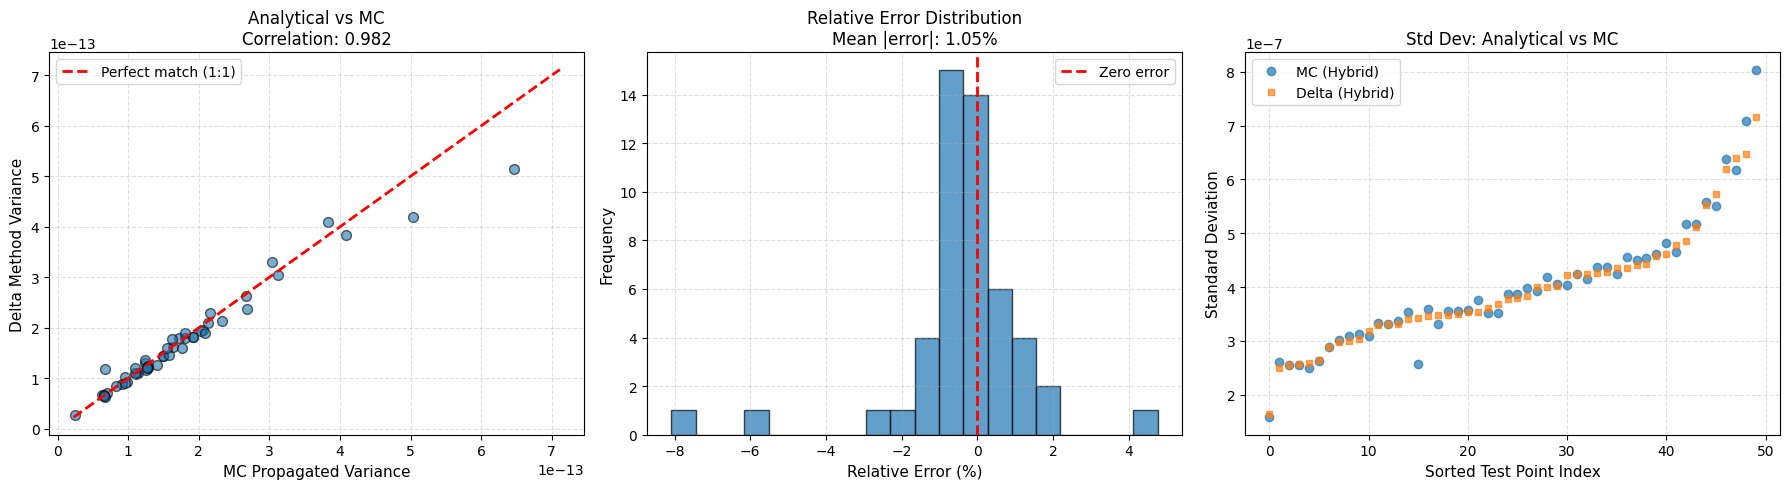


ASSESSMENT:
 EXCELLENT: Analytical propagation matches MC very well (<10% error)
 Strong correlation - relative magnitudes are correct

CHECKING 5 WORST-MATCHING POINTS:
Point 16 (Original Idx: 1831):
  MC=6.4686e-13, Analytical=5.1373e-13, Rel Error=-8.08%
Point 12 (Original Idx: 1001):
  MC=5.0283e-13, Analytical=4.1910e-13, Rel Error=-5.57%
Point 45 (Original Idx: 527):
  MC=6.6550e-14, Analytical=1.1742e-13, Rel Error=4.77%
Point 49 (Original Idx: 602):
  MC=2.6845e-13, Analytical=2.3664e-13, Rel Error=-2.51%
Point 27 (Original Idx: 1803):
  MC=3.0311e-13, Analytical=3.2926e-13, Rel Error=2.01%


In [12]:

# MONTE CARLO VALIDATION (for Delta Method)

print("\n" + "="*70)
print("VALIDATING DELTA METHOD WITH MONTE CARLO SIMULATION")
print("="*70)

def validate_hybrid_uncertainty_mc(gpr_model, scaler, X_test_orig, X_test_z,
                                   Sigma_z, input_var_analytical,
                                   n_samples=500, n_test_points=50):

    n_total = len(X_test_z)
    if n_total > n_test_points:
        test_indices = np.random.choice(n_total, n_test_points, replace=False)
    else:
        test_indices = np.arange(n_total)
        n_test_points = n_total

    input_var_mc_list = []
    input_var_analyt_subset = [] # Analytical variances for the chosen subset

    print(f"Running Monte Carlo validation on {n_test_points} random test points...")
    print(f"Sampling {n_samples} perturbed inputs per point...")

    # Add clipping for robustness, in case Sigma_z is not perfectly PD
    try:
        np.linalg.cholesky(Sigma_z)
        Sigma_z_clipped = Sigma_z
    except np.linalg.LinAlgError:
        print("Warning: Sigma_z not positive definite. Applying eigenvalue clipping for MCS.")
        eigvals, eigvecs = np.linalg.eigh(Sigma_z)
        eigvals_clipped = np.clip(eigvals, 1e-12, None)
        Sigma_z_clipped = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

    for idx in tqdm(test_indices, desc="Validating Test Points"):
        # Get the mean (nominal point) in z-space
        z_mean = X_test_z[idx]

        # 1. Monte Carlo: Sample perturbed inputs in z-space
        z_samples = np.random.multivariate_normal(z_mean, Sigma_z_clipped, size=n_samples)

        # 2. Convert samples back to original physical space
        x_orig_samples = scaler.inverse_transform(z_samples)

        # 3. Predict output for all samples using the FULL HYBRID MODEL
        y_samples_pred = hybrid_predict(
            x_orig_samples,
            z_samples,
            gpr_model,
            return_std=False
        )

        # 4. Empirical variance from MC samples
        var_mc = np.var(y_samples_pred, ddof=1)
        input_var_mc_list.append(var_mc)

        # 5. Store the corresponding analytical estimate
        input_var_analyt_subset.append(input_var_analytical[idx])

    input_var_mc = np.array(input_var_mc_list)
    input_var_analyt = np.array(input_var_analyt_subset)

    # --- Validation Metrics ---
    # Clip at 0 to avoid issues with sqrt of tiny negative numbers
    input_var_mc_safe = np.clip(input_var_mc, 0, None)
    input_var_analyt_safe = np.clip(input_var_analyt, 0, None)

    relative_error = (input_var_analyt - input_var_mc) / (input_var_mc + 1e-12)
    mean_rel_error = np.mean(np.abs(relative_error))

    # Correlation between analytical and MC
    correlation = np.corrcoef(input_var_analyt, input_var_mc)[0, 1]

    # RMSE in standard deviation space
    rmse_std = np.sqrt(np.mean((np.sqrt(input_var_analyt_safe) - np.sqrt(input_var_mc_safe))**2))

    print("\n" + "="*70)
    print("MONTE CARLO VALIDATION RESULTS (HYBRID MODEL)")
    print("="*70)
    print(f"Mean absolute relative error: {mean_rel_error:.4f} ({mean_rel_error*100:.2f}%)")
    print(f"Correlation (analytical vs MC): {correlation:.4f}")
    print(f"RMSE in std dev space: {rmse_std:.6e}")
    print(f"\nMean MC variance:           {input_var_mc.mean():.6e}")
    print(f"Mean Analytical variance:   {input_var_analyt.mean():.6e}")
    print("="*70)

    # --- Visual Validation ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Scatter plot: Analytical vs MC
    axes[0].scatter(input_var_mc, input_var_analyt, alpha=0.6, s=50, edgecolors='k')
    min_val = min(input_var_mc.min(), input_var_analyt.min()) * 0.9
    max_val = max(input_var_mc.max(), input_var_analyt.max()) * 1.1
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect match (1:1)')
    axes[0].set_xlabel('MC Propagated Variance', fontsize=11)
    axes[0].set_ylabel('Delta Method Variance', fontsize=11)
    axes[0].set_title(f'Analytical vs MC\nCorrelation: {correlation:.3f}', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.4)

    # 2. Relative error distribution
    axes[1].hist(relative_error * 100, bins=20, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    axes[1].set_xlabel('Relative Error (%)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title(f'Relative Error Distribution\nMean |error|: {mean_rel_error*100:.2f}%',
                      fontsize=12)
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.4)

    # 3. Standard deviation comparison
    std_mc = np.sqrt(input_var_mc_safe)
    std_analyt = np.sqrt(input_var_analyt_safe)
    x_points = np.arange(len(test_indices))
    sort_order = np.argsort(std_analyt)
    axes[2].plot(x_points, std_mc[sort_order], 'o', label='MC (Hybrid)', alpha=0.7, markersize=6)
    axes[2].plot(x_points, std_analyt[sort_order], 's', label='Delta (Hybrid)', alpha=0.7, markersize=4)
    axes[2].set_xlabel('Sorted Test Point Index', fontsize=11)
    axes[2].set_ylabel('Standard Deviation', fontsize=11)
    axes[2].set_title('Std Dev: Analytical vs MC', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

    # --- Assessment ---
    print("\nASSESSMENT:")
    if mean_rel_error < 0.1:
        print(" EXCELLENT: Analytical propagation matches MC very well (<10% error)")
    elif mean_rel_error < 0.2:
        print(" GOOD: Analytical propagation reasonably accurate (<20% error)")
    elif mean_rel_error < 0.3:
        print(" ACCEPTABLE: Moderate discrepancy (20-30% error) - model may have non-linearities")
    else:
        print(" POOR: Large discrepancy (>30% error) - verify gradient computation or Sigma_z")

    if correlation > 0.95:
        print(" Strong correlation - relative magnitudes are correct")
    elif correlation > 0.8:
        print(" Moderate correlation - some systematic bias may exist")
    else:
        print(" Weak correlation - fundamental issue with propagation")

    return {
        'input_var_mc': input_var_mc,
        'input_var_analytical': input_var_analyt,
        'mean_rel_error': mean_rel_error,
        'correlation': correlation,
        'rmse_std': rmse_std,
        'test_indices': test_indices
    }


np.random.seed(42)

# Run Monte Carlo validation
validation_results = validate_hybrid_uncertainty_mc(
    gpr_model=gpr,
    scaler=scaler,
    X_test_orig=X_test,         # Pass the original-space test data
    X_test_z=X_test_z,
    Sigma_z=Sigma_z,
    input_var_analytical=input_var,
    n_samples=500,
    n_test_points=50
)

print("\n" + "="*70)
print("CHECKING 5 WORST-MATCHING POINTS:")
print("="*70)

abs_error = np.abs(validation_results['input_var_analytical'] - validation_results['input_var_mc'])
idx_worst_sorted = np.argsort(abs_error)[-5:][::-1]

for i in idx_worst_sorted:
    mc_val = validation_results['input_var_mc'][i]
    analyt_val = validation_results['input_var_analytical'][i]
    rel_err = (analyt_val - mc_val) / (mc_val + 1e-12) * 100
    original_test_idx = validation_results['test_indices'][i]
    print(f"Point {i} (Original Idx: {original_test_idx}):")
    print(f"  MC={mc_val:.4e}, Analytical={analyt_val:.4e}, Rel Error={rel_err:.2f}%")

print("="*70)
